### This is where we join all the tables to make a functioning prediction dataframe
To what extent is it possible to divide the property information into year?

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
%matplotlib inline

In [2]:
def convert_to_point(coords):
    
    coords = coords.split(',')
    lat = float(coords[0][1:])
    lon = float(coords[1][:-1])
    
    return Point(lon,lat)

In [3]:
SF_blocks = gpd.read_file('../datasets/census_blocks/SF_block_2010.shp')

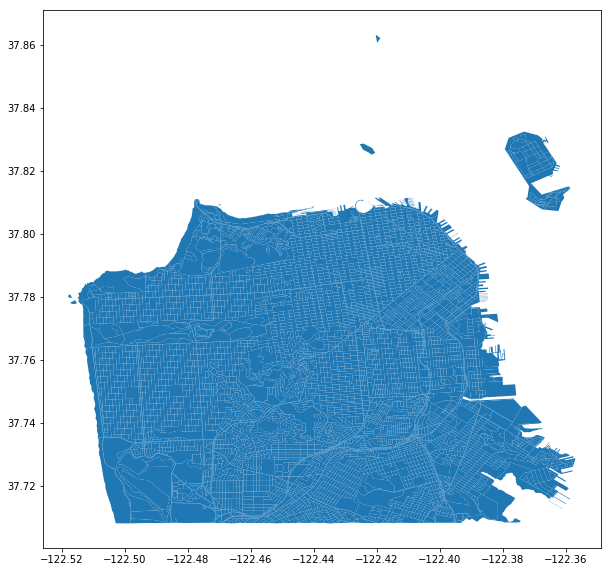

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
SF_blocks.plot(ax=ax,legend=True)
#plt.xlim([-122.53,-122.35])
#plt.ylim([37.70,37.84])

In [5]:
SF_blocks.head()

,GISJOIN,geometry
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...
1,G06007500213002000,POLYGON ((-122.4384740001121 37.75102399977603...
2,G06007500205003004,POLYGON ((-122.4358080000585 37.75762299984262...
3,G06007500212001003,"POLYGON ((-122.436600000268 37.75435900004783,..."
4,G06007500211004001,"POLYGON ((-122.4323309993808 37.7562269999388,..."


In [9]:
properties = pd.read_csv('../datasets/property/Property_Tax.csv',low_memory=False)

In [10]:
def add_year(val):

    '''Time timeline classifiction for the tax data is different from all other datasets.
    The tax year runs from July 1st to June 30th. A record with roll year of 2008 means the year 2008-2009,
    for example. Because we want to predict the future, we need to use 2017's taxroll information with 2018's
    other features. Thus we need to add 1 to each year represented here
    '''

    return int(val)+1

In [11]:
properties = properties.dropna(subset=['the_geom','Closed Roll Year'])

In [12]:
#Representing year is one year ahead of the roll year
properties['Representing year'] = properties['Closed Roll Year'].apply(add_year)

In [ ]:
properties.columns

In [13]:
properties['Representing year'].unique()

array([2008, 2017, 2011, 2016, 2009, 2014, 2013, 2010, 2012, 2015, 2018])

In [14]:
properties_by_year = properties.groupby("Representing year").count()

In [15]:
properties_by_year

,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,...,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Analysis Neighborhood,the_geom,Row ID
Representing year,,,,,,,,,,,,,,,,,,,,,
2008,197614,197614,197614,197614,197614,197614,197614,197614,197614,197614,...,197614,197614,197614,197502,197579,197502,197614,197614,197614,197614
2009,200019,200019,200019,200019,200019,200019,200018,200018,200018,200018,...,200019,200019,200019,199910,199984,199910,200019,200019,200019,200019
2010,200761,200761,200761,200761,200761,200761,200752,200752,200752,200752,...,200761,200761,200761,200747,200750,200747,200761,200761,200761,200761
2011,202942,202942,202942,202942,202942,202942,202935,202935,202935,202935,...,202942,202942,202942,202928,202931,202928,202942,202942,202942,202942
2012,193728,193728,193728,193728,193728,193728,193719,193719,193719,193719,...,193728,193728,193728,193713,193716,193713,193728,193728,193728,193728
2013,204009,204009,204009,204009,204009,204009,204008,204008,204008,204008,...,204009,204009,204009,203996,203999,203996,204009,204009,204009,204009
2014,205395,205395,205395,205395,205395,205395,205395,205395,205395,205395,...,205395,205395,205395,205395,205395,205395,205395,205395,205395,205395
2015,206570,206570,206570,206570,206570,206570,206299,206299,206299,206299,...,206570,206570,206570,206565,206565,206565,206570,206570,206570,206570
2016,208758,208758,208758,208758,208758,208758,208758,208758,208758,208758,...,208758,208758,208758,208758,208758,208758,208758,208758,208758,208758


In [16]:
properties = properties[['Representing year','Assessed Land Value','Number of Units','Year Property Built','Use Code','Construction Type','the_geom','Lot Area']]
properties.dropna(inplace=True)

In [17]:
properties_by_year = properties.groupby("Representing year").count()
properties_by_year

,Assessed Land Value,Number of Units,Year Property Built,Use Code,Construction Type,the_geom,Lot Area
Representing year,,,,,,,
2008,166170,166170,166170,166170,166170,166170,166170
2009,165961,165961,165961,165961,165961,165961,165961
2010,165755,165755,165755,165755,165755,165755,165755
2011,165602,165602,165602,165602,165602,165602,165602
2012,157511,157511,157511,157511,157511,157511,157511
2013,164917,164917,164917,164917,164917,164917,164917
2014,164633,164633,164633,164633,164633,164633,164633
2015,164539,164539,164539,164539,164539,164539,164539
2016,164751,164751,164751,164751,164751,164751,164751


In [18]:
properties['geometry'] = properties['the_geom'].apply(convert_to_point)

In [19]:
properties_geo = gpd.GeoDataFrame(properties,geometry='geometry')
properties_geo.crs = {'init': 'epsg:4326'}
# Merge properties - find the block that contains each property
intersections = gpd.sjoin(SF_blocks, properties_geo, how="left", op='contains')

In [20]:
intersections.isna().sum()
intersections.dropna(inplace=True)

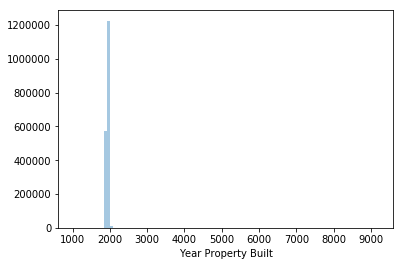

In [21]:
sns.distplot(intersections['Year Property Built'],kde=False,bins=100)
#This is odd - looks like some properties have incorrect build years!

In [22]:
#Tidy up property build year distributions
intersections = intersections[(intersections['Year Property Built']<=2018) & (intersections['Year Property Built']>=1890)]

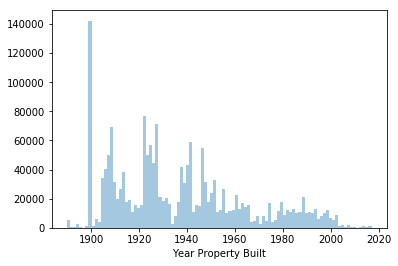

In [23]:
sns.distplot(intersections['Year Property Built'],kde=False,bins=100)

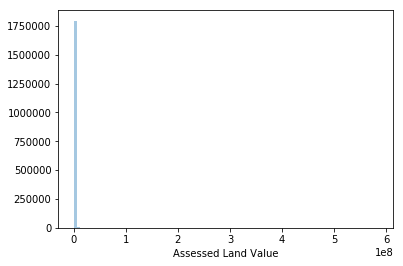

In [24]:
sns.distplot(intersections['Assessed Land Value'],kde=False,bins=100)

In [25]:
#Removed everything above 95 percetile of land value
intersections = intersections[intersections['Assessed Land Value'] < intersections['Assessed Land Value'].quantile(.95)]

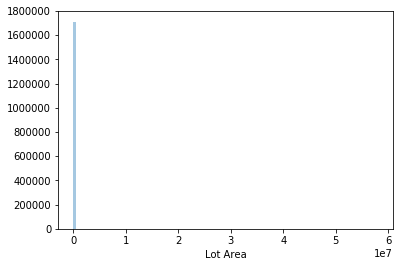

In [26]:
sns.distplot(intersections['Lot Area'],kde=False,bins=100)

In [27]:
#Removed everything above 95 percetile of lot area, and lots with recorded area of 0
intersections = intersections[intersections['Lot Area'] < intersections['Lot Area'].quantile(.95)]
intersections = intersections[intersections['Lot Area'] > 0]

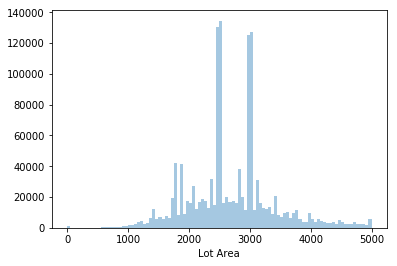

In [28]:
sns.distplot(intersections['Lot Area'],kde=False,bins=100)

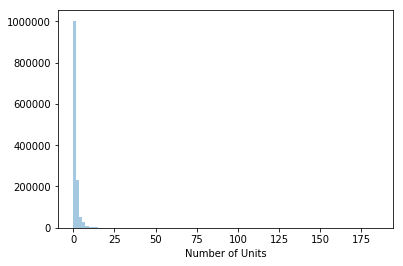

In [29]:
#This seems more reasonable
sns.distplot(intersections['Number of Units'],kde=False,bins=100)

In [31]:
#We still have plenty of properties in each year. Hoprfully enough to fill in the blank census regions
properties_by_year = intersections.groupby("Representing year").count()
properties_by_year

,GISJOIN,geometry,index_right,Assessed Land Value,Number of Units,Year Property Built,Use Code,Construction Type,the_geom,Lot Area
Representing year,,,,,,,,,,
2008.0,125690,125690,125690,125690,125690,125690,125690,125690,125690,125690
2009.0,124752,124752,124752,124752,124752,124752,124752,124752,124752,124752
2010.0,123986,123986,123986,123986,123986,123986,123986,123986,123986,123986
2011.0,123598,123598,123598,123598,123598,123598,123598,123598,123598,123598
2012.0,117392,117392,117392,117392,117392,117392,117392,117392,117392,117392
2013.0,122234,122234,122234,122234,122234,122234,122234,122234,122234,122234
2014.0,121526,121526,121526,121526,121526,121526,121526,121526,121526,121526
2015.0,120752,120752,120752,120752,120752,120752,120752,120752,120752,120752
2016.0,119566,119566,119566,119566,119566,119566,119566,119566,119566,119566


In [63]:
means = intersections[['GISJOIN','Representing year','Year Property Built','Assessed Land Value','Number of Units','Lot Area']].groupby(['GISJOIN','Representing year']).mean()

In [64]:
means = means.reset_index()

In [65]:
means.head()

,GISJOIN,Representing year,Year Property Built,Assessed Land Value,Number of Units,Lot Area
0,G06007500101001011,2008.0,1923.0,291443.0,2.0,3515.625
1,G06007500101001011,2009.0,1923.0,297271.0,2.0,3515.625
2,G06007500101001011,2010.0,1923.0,303216.0,2.0,3515.625
3,G06007500101001011,2011.0,1923.0,302497.5,2.0,3515.625
4,G06007500101001011,2012.0,1923.0,304774.0,2.0,3515.625


In [66]:
Means_per_block_year = means
Means_per_block_year['Year'] = Means_per_block_year['Representing year']
Means_per_block_year.drop('Representing year',axis=1,inplace=True)
Means_per_block_year['GISYEARJOIN'] = Means_per_block_year.apply(generateGISyearjoin,axis=1)

In [67]:
counts_use = intersections[['GISJOIN','Representing year','Use Code','Construction Type']].groupby(['GISJOIN','Representing year','Use Code']).count()

In [68]:
counts_use = counts_use.unstack(2)

In [69]:
counts_use.columns = counts_use.columns.droplevel(0)

In [70]:
counts_use.columns = [str(cname) for cname in list(counts_use.columns)]

In [71]:
counts_use.fillna(0,inplace=True)
b = counts_use.div(counts_use.sum(axis=1), axis=0)

In [72]:
b.reset_index(inplace=True)

In [73]:
b.head()

,GISJOIN,Representing year,COMH,COMM,COMO,COMR,GOVT,IND,MISC,MRES,SRES
0,G06007500101001011,2008.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0
1,G06007500101001011,2009.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0
2,G06007500101001011,2010.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0
3,G06007500101001011,2011.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0
4,G06007500101001011,2012.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0


In [74]:
cols = list(b.columns)

In [75]:
b['Sum'] = b[cols[2:]].sum(axis=1)

In [76]:
def fillunknown(sumval):
    if sumval == 0:
        return 1
    else:
        return 0

In [77]:
b['UnkownUseType']=b['Sum'].apply(fillunknown)

In [78]:
Use_per_block_year = b
Use_per_block_year['Year'] = Use_per_block_year['Representing year']
Use_per_block_year.drop(['Representing year','Sum'],axis=1,inplace=True)
Use_per_block_year['GISYEARJOIN'] = Use_per_block_year.apply(generateGISyearjoin,axis=1)

In [79]:
counts_type = intersections[['GISJOIN','Representing year','Use Code','Construction Type']].groupby(['GISJOIN','Representing year','Construction Type']).count()

In [80]:
a = counts_type.unstack(2)

In [81]:
a.columns = a.columns.droplevel(0)
a.columns = [str(cname) for cname in list(a.columns)]
a.fillna(0,inplace=True)
b = a.div(a.sum(axis=1), axis=0)
b.reset_index(inplace=True)
print(b.columns)
#Sum over all the unknown types
b['S'] = b[['1','BRI','F','R','REI','ROW','S','STE','WOO']].sum(axis=1)
#Drop the other unknown types
b = b.drop(['1','BRI','F','R','REI','ROW','STE','WOO'],axis=1)

Index(['GISJOIN', 'Representing year', '1', 'A', 'B', 'BRI', 'C', 'D', 'F',
       'R', 'REI', 'ROW', 'S', 'STE', 'WOO'],
      dtype='object')


In [82]:
Type_per_block_year = b
Type_per_block_year['Year'] = Type_per_block_year['Representing year']
Type_per_block_year.drop('Representing year',axis=1,inplace=True)

In [83]:
def generateGISyearjoin(row):
    
    return str(row['GISJOIN'])+str(int(row['Year']))

In [84]:
Type_per_block_year['GISYEARJOIN'] = Type_per_block_year.apply(generateGISyearjoin,axis=1)

In [85]:
Type_per_block_year.head()

,GISJOIN,A,B,C,D,S,Year,GISYEARJOIN
0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2008.0,G060075001010010112008
1,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2009.0,G060075001010010112009
2,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2010.0,G060075001010010112010
3,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2011.0,G060075001010010112011
4,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2012.0,G060075001010010112012


In [86]:
Use_per_block_year.head()

,GISJOIN,COMH,COMM,COMO,COMR,GOVT,IND,MISC,MRES,SRES,UnkownUseType,Year,GISYEARJOIN
0,G06007500101001011,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0,2008.0,G060075001010010112008
1,G06007500101001011,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0,2009.0,G060075001010010112009
2,G06007500101001011,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0,2010.0,G060075001010010112010
3,G06007500101001011,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0,2011.0,G060075001010010112011
4,G06007500101001011,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0,2012.0,G060075001010010112012


In [87]:
Means_per_block_year.head()

,GISJOIN,Year Property Built,Assessed Land Value,Number of Units,Lot Area,Year,GISYEARJOIN
0,G06007500101001011,1923.0,291443.0,2.0,3515.625,2008.0,G060075001010010112008
1,G06007500101001011,1923.0,297271.0,2.0,3515.625,2009.0,G060075001010010112009
2,G06007500101001011,1923.0,303216.0,2.0,3515.625,2010.0,G060075001010010112010
3,G06007500101001011,1923.0,302497.5,2.0,3515.625,2011.0,G060075001010010112011
4,G06007500101001011,1923.0,304774.0,2.0,3515.625,2012.0,G060075001010010112012


## Merge

In [88]:
d1 = Means_per_block_year.merge(Use_per_block_year,how='outer',on='GISYEARJOIN')

In [89]:
d2 = d1.merge(Type_per_block_year,how='outer',on='GISYEARJOIN')

In [90]:
d3 = d2.drop(['GISJOIN_x','Year_x','GISJOIN_y','Year_y'],axis=1)

In [91]:
d3.columns

Index(['Year Property Built', 'Assessed Land Value', 'Number of Units',
       'Lot Area', 'GISYEARJOIN', 'COMH', 'COMM', 'COMO', 'COMR', 'GOVT',
       'IND', 'MISC', 'MRES', 'SRES', 'UnkownUseType', 'GISJOIN', 'A', 'B',
       'C', 'D', 'S', 'Year'],
      dtype='object')

In [92]:
d3.head()

,Year Property Built,Assessed Land Value,Number of Units,Lot Area,GISYEARJOIN,COMH,COMM,COMO,COMR,GOVT,...,MRES,SRES,UnkownUseType,GISJOIN,A,B,C,D,S,Year
0,1923.0,291443.0,2.0,3515.625,G060075001010010112008,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2008.0
1,1923.0,297271.0,2.0,3515.625,G060075001010010112009,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2009.0
2,1923.0,303216.0,2.0,3515.625,G060075001010010112010,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2010.0
3,1923.0,302497.5,2.0,3515.625,G060075001010010112011,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2011.0
4,1923.0,304774.0,2.0,3515.625,G060075001010010112012,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2012.0


In [93]:
SF_blocks.head()

,GISJOIN,geometry
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...
1,G06007500213002000,POLYGON ((-122.4384740001121 37.75102399977603...
2,G06007500205003004,POLYGON ((-122.4358080000585 37.75762299984262...
3,G06007500212001003,"POLYGON ((-122.436600000268 37.75435900004783,..."
4,G06007500211004001,"POLYGON ((-122.4323309993808 37.7562269999388,..."


In [94]:
d3.isna().sum()

Year Property Built    0
Assessed Land Value    0
Number of Units        0
Lot Area               0
GISYEARJOIN            0
COMH                   0
COMM                   0
COMO                   0
COMR                   0
GOVT                   0
IND                    0
MISC                   0
MRES                   0
SRES                   0
UnkownUseType          0
GISJOIN                0
A                      0
B                      0
C                      0
D                      0
S                      0
Year                   0
dtype: int64

In [96]:
d3.to_csv('Properties_with_corrected_year.csv',index=None)

### Yearjoin the fires data

In [97]:
    datapath = '../datasets/fire/'
    
    #This should be 2008, ending in 2018 since we want to predict fires
    #one year in advance of the other variables 
    
    date_to_start = '2007-01-01'
    fire_incidents = pd.read_csv(datapath+'Fire_Incidents.csv',low_memory=False)

    fire_incidents['Incident_Date'] = pd.to_datetime(fire_incidents['Incident Date'])
    fire_incidents.sort_values(by='Incident_Date',inplace=True)

    #Get only the data since 2007 (when we have building information)
    fire_incidents = fire_incidents[fire_incidents['Incident_Date']>=date_to_start]

    #Remove rows that don't have location information
    fires_dataset_cleaned = fire_incidents.dropna(subset=['Location'])

    #### NOTE: May want to edit this
    #Keep only the fire instances that we care about
    #These numbers refer to codes in the Primary Situation column of the fires database
    structure_fire = ['111','112']
    vehicle_fire = ['130','131','132','137','138']
    #maybe need to split these further?
    external_fire = ['140','141','142','143','151','152','153','154','155','160',\
            '161','162','164','170','173']
    ####

    searchfor = structure_fire + vehicle_fire + external_fire
    fires_dataset_cleaned = fires_dataset_cleaned[fires_dataset_cleaned['Primary Situation']\
                                    .str.contains('|'.join(searchfor))]

    #Add columns for the various fire types
    fires_dataset_cleaned['Structure_fire'] = fires_dataset_cleaned['Primary Situation']\
              .str.contains('|'.join(structure_fire))
    fires_dataset_cleaned['Vehicle_fire'] = fires_dataset_cleaned['Primary Situation']\
              .str.contains('|'.join(vehicle_fire))
    fires_dataset_cleaned['External_fire'] = fires_dataset_cleaned['Primary Situation']\
              .str.contains('|'.join(external_fire))

    fires_dataset_cleaned['geometry'] = fires_dataset_cleaned['Location'].apply(convert_to_point)

In [98]:
    fires_dataset_geo = gpd.GeoDataFrame(fires_dataset_cleaned,geometry='geometry')
    fires_dataset_geo.crs = {'init': 'epsg:4326'}

    fires_dataset_geo['Structure_fire'] = fires_dataset_geo['Structure_fire'].astype(int)
    fires_dataset_geo['Vehicle_fire'] = fires_dataset_geo['Vehicle_fire'].astype(int)
    fires_dataset_geo['External_fire'] = fires_dataset_geo['External_fire'].astype(int)
    fires_dataset_geo['Incident_Year'] = fires_dataset_geo['Incident_Date'].apply(lambda x: int(x.year))

In [99]:
intersections = gpd.sjoin(SF_blocks, fires_dataset_geo, how="left", op='contains')
Fires_per_block_train = intersections[['GISJOIN','Incident_Year','Structure_fire','Vehicle_fire','External_fire']].groupby(['GISJOIN','Incident_Year']).sum()

In [100]:
Fires_per_block_train.reset_index(inplace=True)

In [101]:
Fires_per_block_train['Year'] = Fires_per_block_train['Incident_Year']
Fires_per_block_train.drop('Incident_Year',axis=1,inplace=True)

In [102]:
Fires_per_block_train['GISYEARJOIN'] = Fires_per_block_train.apply(generateGISyearjoin,axis=1)

In [103]:
Fires_per_block_train.head()

,GISJOIN,Structure_fire,Vehicle_fire,External_fire,Year,GISYEARJOIN
0,G06007500101001001,1.0,0.0,2.0,2007.0,G060075001010010012007
1,G06007500101001001,5.0,0.0,1.0,2008.0,G060075001010010012008
2,G06007500101001001,1.0,0.0,1.0,2009.0,G060075001010010012009
3,G06007500101001001,1.0,0.0,0.0,2010.0,G060075001010010012010
4,G06007500101001001,4.0,0.0,1.0,2011.0,G060075001010010012011


In [104]:
Fires_per_block_train.isna().sum()

GISJOIN           0
Structure_fire    0
Vehicle_fire      0
External_fire     0
Year              0
GISYEARJOIN       0
dtype: int64

In [105]:
SF_blocks.head()

,GISJOIN,geometry
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...
1,G06007500213002000,POLYGON ((-122.4384740001121 37.75102399977603...
2,G06007500205003004,POLYGON ((-122.4358080000585 37.75762299984262...
3,G06007500212001003,"POLYGON ((-122.436600000268 37.75435900004783,..."
4,G06007500211004001,"POLYGON ((-122.4323309993808 37.7562269999388,..."


In [106]:
## Make SFblocksyearjoin
IDs = []
blocks = []
newyears = []
block_polys = list(SF_blocks['geometry'])
block_IDs = list(SF_blocks['GISJOIN'])

In [107]:
years = Fires_per_block_train['Year'].unique().astype(int)

In [108]:
for i in range(len(block_IDs)):
    block = block_polys[i]
    ID = str(block_IDs[i])
    for year in years:
        IDs.append(ID+str(year))
        blocks.append(block) 
        newyears.append(year)

In [109]:
SF_blocks_years = gpd.GeoDataFrame({'GISYEARJOIN':IDs,'geometry':blocks,'IDyear':newyears})

In [110]:
SF_blocks_years.head()

,GISYEARJOIN,geometry,IDyear
0,G060075002130020022007,POLYGON ((-122.4406159997011 37.75090200039605...,2007
1,G060075002130020022008,POLYGON ((-122.4406159997011 37.75090200039605...,2008
2,G060075002130020022009,POLYGON ((-122.4406159997011 37.75090200039605...,2009
3,G060075002130020022010,POLYGON ((-122.4406159997011 37.75090200039605...,2010
4,G060075002130020022011,POLYGON ((-122.4406159997011 37.75090200039605...,2011


In [111]:
a = SF_blocks_years.merge(Fires_per_block_train,how='outer',on='GISYEARJOIN')

In [112]:
a.isna().sum()

GISYEARJOIN           0
geometry              0
IDyear                0
GISJOIN           84439
Structure_fire    84439
Vehicle_fire      84439
External_fire     84439
Year              84439
dtype: int64

In [113]:
np.arange(2007,2019)

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [114]:
a.replace(np.nan,0,inplace=True)

In [115]:
a.head()

,GISYEARJOIN,geometry,IDyear,GISJOIN,Structure_fire,Vehicle_fire,External_fire,Year
0,G060075002130020022007,POLYGON ((-122.4406159997011 37.75090200039605...,2007,0,0.0,0.0,0.0,0.0
1,G060075002130020022008,POLYGON ((-122.4406159997011 37.75090200039605...,2008,0,0.0,0.0,0.0,0.0
2,G060075002130020022009,POLYGON ((-122.4406159997011 37.75090200039605...,2009,0,0.0,0.0,0.0,0.0
3,G060075002130020022010,POLYGON ((-122.4406159997011 37.75090200039605...,2010,0,0.0,0.0,0.0,0.0
4,G060075002130020022011,POLYGON ((-122.4406159997011 37.75090200039605...,2011,0,0.0,0.0,0.0,0.0


In [116]:
b = a[a['IDyear']==2009]

In [117]:
len(b)

7336

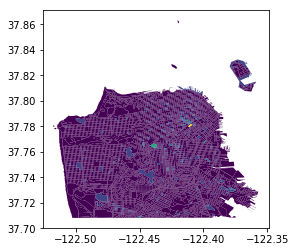

In [118]:
b.plot(column='Structure_fire',vmin=0)

In [119]:
a.drop('geometry',axis=1).to_csv('All_associated_fires.csv',index=False)

### Yearjoin the crimes data

In [120]:
crime = pd.read_csv("../datasets/crime/Crime.csv",low_memory=False)

In [121]:
crime.dropna(subset=['Date','Location','Category'],inplace=True)

In [122]:
crime['Date'] = pd.to_datetime(crime['Date'])
crime = crime[crime['Date']>'2007-01-01']

In [123]:
crime = crime[~crime['Category'].str.contains('NON-CRIMINAL|SECONDARY CODES|RECOVERED VEHICLE')]

In [124]:
crime['CrimeIsArson'] = crime['Category']=='ARSON'
crime['CrimeIsOther'] = crime['Category']!='ARSON'

In [125]:
crime['geometry'] = crime['Location'].apply(convert_to_point)
crime['Year'] = crime['Date'].apply(lambda x: int(x.year))

In [126]:
crime_geo = gpd.GeoDataFrame(crime,geometry='geometry')
crime_geo.crs = {'init': 'epsg:4326'}

In [127]:
# Merge crimes - find the block that contains each crime
intersections = gpd.sjoin(SF_blocks, crime_geo, how="left", op='contains')

In [128]:
intersections.head()

,GISJOIN,geometry,index_right,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,CrimeIsArson,CrimeIsOther,Year
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...,1965308.0,186072264.0,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,2018-03-25,18:00,MISSION,NONE,24TH ST / HOFFMAN AV,-122.440617,37.750901,"(37.750901030742206, -122.44061711785501)",1.860723e+13,False,True,2018.0
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...,1970349.0,186091430.0,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,2018-04-20,17:00,MISSION,NONE,HOFFMAN AV / 24TH ST,-122.440617,37.750901,"(37.750901030742206, -122.44061711785501)",1.860914e+13,False,True,2018.0
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...,2017543.0,176010729.0,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,2017-01-10,03:45,MISSION,NONE,HOFFMAN AV / 24TH ST,-122.440617,37.750901,"(37.750901030742206, -122.44061711785501)",1.760107e+13,False,True,2017.0
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...,1845512.0,160548932.0,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,2016-07-05,09:45,MISSION,NONE,HOFFMAN AV / 25TH ST,-122.440617,37.750901,"(37.750901030742206, -122.44061711785501)",1.605489e+13,False,True,2016.0
0,G06007500213002002,POLYGON ((-122.4406159997011 37.75090200039605...,2026176.0,160548136.0,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,2016-07-06,19:45,MISSION,NONE,24TH ST / HOFFMAN AV,-122.440617,37.750901,"(37.750901030742206, -122.44061711785501)",1.605481e+13,False,True,2016.0


In [129]:
intersections.replace(np.nan,0,inplace=True)

In [130]:
ncrimes_per_block = intersections[['GISJOIN','Year','CrimeIsArson','CrimeIsOther']].groupby(['GISJOIN','Year']).sum()

In [132]:
ncrimes_per_block.reset_index(inplace=True)

In [133]:
ncrimes_per_block.head()

,GISJOIN,Year,CrimeIsArson,CrimeIsOther
0,G06007500101001001,2007.0,0,366
1,G06007500101001001,2008.0,0,330
2,G06007500101001001,2009.0,0,254
3,G06007500101001001,2010.0,0,216
4,G06007500101001001,2011.0,1,251


In [134]:
ncrimes_per_block['GISYEARJOIN'] = ncrimes_per_block.apply(generateGISyearjoin,axis=1)

In [141]:
ncrimes_per_block['CrimeIsArson'] = ncrimes_per_block['CrimeIsArson'].astype(int)
ncrimes_per_block['CrimeIsOther'] = ncrimes_per_block['CrimeIsOther'].astype(int)

In [142]:
ncrimes_per_block.head()

,GISJOIN,Year,CrimeIsArson,CrimeIsOther,GISYEARJOIN
0,G06007500101001001,2007.0,0,366,G060075001010010012007
1,G06007500101001001,2008.0,0,330,G060075001010010012008
2,G06007500101001001,2009.0,0,254,G060075001010010012009
3,G06007500101001001,2010.0,0,216,G060075001010010012010
4,G06007500101001001,2011.0,1,251,G060075001010010012011


In [143]:
ncrimes_per_block.to_csv('All_associted_crimes.csv',index=False)

### Yearjoin the inspections data

In [144]:
fire_inspections = pd.read_csv("../datasets/fire/Fire_Inspections.csv",low_memory=False)

In [145]:
fire_inspections.dropna(subset=["Location","Inspection Start Date","Inspection End Date"],inplace=True)

In [146]:
fire_inspections['Inspection Start Date'] = pd.to_datetime(fire_inspections['Inspection Start Date'])

In [147]:
#Get only the data since 2007 (when we have building information)
fire_inspections = fire_inspections[fire_inspections['Inspection Start Date']>='2007-01-01']

In [148]:
#Get the number of complaints
fire_inspections['Was complaint'] = fire_inspections['Inspection Type Description']=='complaint inspection'

In [149]:
fire_inspections['geometry'] = fire_inspections['Location'].apply(convert_to_point)
fire_inspections['Year'] = fire_inspections['Inspection Start Date'].apply(lambda x: x.year)

In [150]:
#Convert to geo dataframe
fire_inspections_geo = gpd.GeoDataFrame(fire_inspections,geometry='geometry')
fire_inspections_geo.crs = {'init': 'epsg:4326'}

In [151]:
# Merge inspections - find the block that contains each fire
intersections = gpd.sjoin(SF_blocks, fire_inspections_geo, how="inner", op='contains')

In [152]:
intersections.replace(np.nan,0,inplace=True)

In [153]:
ninspections_per_block = intersections[['GISJOIN','Inspection Number','Year']].groupby(['GISJOIN','Year']).count()

In [154]:
ninspections_per_block.reset_index(inplace=True)

In [155]:
ninspections_per_block.head()

,GISJOIN,Year,Inspection Number
0,G06007500101001001,2007,30
1,G06007500101001001,2008,43
2,G06007500101001001,2009,92
3,G06007500101001001,2010,49
4,G06007500101001001,2011,58


In [156]:
ninspections_per_block['GISYEARJOIN'] = ninspections_per_block.apply(generateGISyearjoin,axis=1)

In [157]:
ninspections_per_block.head()

,GISJOIN,Year,Inspection Number,GISYEARJOIN
0,G06007500101001001,2007,30,G060075001010010012007
1,G06007500101001001,2008,43,G060075001010010012008
2,G06007500101001001,2009,92,G060075001010010012009
3,G06007500101001001,2010,49,G060075001010010012010
4,G06007500101001001,2011,58,G060075001010010012011


In [158]:
ncomplaints_per_block = intersections[['GISJOIN','Was complaint','Year']].groupby(['GISJOIN','Year']).sum()

In [159]:
ncomplaints_per_block.reset_index(inplace=True)

In [160]:
ncomplaints_per_block['GISYEARJOIN'] = ncomplaints_per_block.apply(generateGISyearjoin,axis=1)

In [163]:
ncomplaints_per_block.head(10)

,GISJOIN,Year,Was complaint,GISYEARJOIN
0,G06007500101001001,2007,0.0,G060075001010010012007
1,G06007500101001001,2008,4.0,G060075001010010012008
2,G06007500101001001,2009,16.0,G060075001010010012009
3,G06007500101001001,2010,5.0,G060075001010010012010
4,G06007500101001001,2011,3.0,G060075001010010012011
5,G06007500101001001,2012,2.0,G060075001010010012012
6,G06007500101001001,2013,4.0,G060075001010010012013
7,G06007500101001001,2014,3.0,G060075001010010012014
8,G06007500101001001,2015,2.0,G060075001010010012015
9,G06007500101001001,2016,2.0,G060075001010010012016


In [164]:
Inspections_per_year_block = ncomplaints_per_block.merge(ninspections_per_block,on='GISYEARJOIN',how='outer')

In [165]:
Inspections_per_year_block.isna().sum()

GISJOIN_x            0
Year_x               0
Was complaint        0
GISYEARJOIN          0
GISJOIN_y            0
Year_y               0
Inspection Number    0
dtype: int64

In [166]:
Inspections_per_year_block.head()

,GISJOIN_x,Year_x,Was complaint,GISYEARJOIN,GISJOIN_y,Year_y,Inspection Number
0,G06007500101001001,2007,0.0,G060075001010010012007,G06007500101001001,2007,30
1,G06007500101001001,2008,4.0,G060075001010010012008,G06007500101001001,2008,43
2,G06007500101001001,2009,16.0,G060075001010010012009,G06007500101001001,2009,92
3,G06007500101001001,2010,5.0,G060075001010010012010,G06007500101001001,2010,49
4,G06007500101001001,2011,3.0,G060075001010010012011,G06007500101001001,2011,58


In [167]:
Inspections_per_year_block.drop(['GISJOIN_x','Year_x','GISJOIN_y','Year_y'],axis=1,inplace=True)

In [168]:
Inspections_per_year_block.head()

,Was complaint,GISYEARJOIN,Inspection Number
0,0.0,G060075001010010012007,30
1,4.0,G060075001010010012008,43
2,16.0,G060075001010010012009,92
3,5.0,G060075001010010012010,49
4,3.0,G060075001010010012011,58


In [169]:
Inspections_per_year_block.to_csv("All_associated_inspections.csv",index=False)

### Yearjoin the violations data

In [170]:
fire_violations = pd.read_csv("../datasets/fire/Fire_Violations.csv",low_memory=False)

In [171]:
fire_violations.dropna(subset=['Location'],inplace=True)
fire_violations['Violation Date'] = pd.to_datetime(fire_violations['Violation Date'])
fire_violations = fire_violations[fire_violations['Violation Date']>'2007-01-01']

In [172]:
fire_violations['geometry'] = fire_violations['Location'].apply(convert_to_point)
fire_violations['Year'] = fire_violations['Violation Date'].apply(lambda x: int(x.year))

In [173]:
#Convert to geo dataframe
fire_violations_geo = gpd.GeoDataFrame(fire_violations,geometry='geometry')
fire_violations_geo.crs = {'init': 'epsg:4326'}

In [174]:
# Merge violations - find the block that contains each fire
intersections = gpd.sjoin(SF_blocks, fire_violations_geo, how="inner", op='contains')

In [175]:
intersections.replace(np.nan,0,inplace=True)

In [176]:
nviolations_per_block = intersections[['GISJOIN','Year','index_right']].groupby(['GISJOIN','Year']).count()

In [177]:
nviolations_per_block.reset_index(inplace=True)

In [178]:
nviolations_per_block['GISYEARJOIN'] = nviolations_per_block.apply(generateGISyearjoin,axis=1)

In [179]:
nviolations_per_block.head()

,GISJOIN,Year,index_right,GISYEARJOIN
0,G06007500101001001,2007,6,G060075001010010012007
1,G06007500101001001,2008,10,G060075001010010012008
2,G06007500101001001,2009,16,G060075001010010012009
3,G06007500101001001,2010,3,G060075001010010012010
4,G06007500101001001,2011,3,G060075001010010012011


In [180]:
nviolations_per_block.columns = ['GISJOIN','Year','Nviolations',"GISYEARJOIN"]

In [181]:
nviolations_per_block.to_csv("All_associated_violations.csv",index=False)

### Join all these tables with the full SF yearblock dataset

We will make a series of tables of the same length, with zeros in the correct year columns

In [182]:
SF_yearblocks = gpd.read_file('../datasets/census_blocks/SF_block_years_2010.shp')

In [183]:
SF_yearblocks.head()

,GISYEARJOI,IDyear,LAT,LON,AREA,geometry
0,G060075002130020022007,2007,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...
1,G060075002130020022008,2008,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...
2,G060075002130020022009,2009,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...
3,G060075002130020022010,2010,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...
4,G060075002130020022011,2011,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...


In [184]:
SF_yearblocks.columns
SF_yearblocks.columns = ['GISYEARJOIN', 'IDyear', 'LAT', 'LON', 'AREA', 'geometry']

In [185]:
a = SF_yearblocks.merge(nviolations_per_block,how='left',on='GISYEARJOIN')

In [186]:
a.replace(np.nan,0,inplace=True)

In [187]:
b = a.merge(Inspections_per_year_block,how='left',on='GISYEARJOIN')

In [188]:
b.replace(np.nan,0,inplace=True)

In [189]:
c = b.merge(ncrimes_per_block,how='left',on='GISYEARJOIN')

In [190]:
c.replace(np.nan,0,inplace=True)

In [191]:
d = c.merge(Fires_per_block_train,how='left',on='GISYEARJOIN')

In [192]:
d.isna().sum()

GISYEARJOIN              0
IDyear                   0
LAT                      0
LON                      0
AREA                     0
geometry                 0
GISJOIN_x                0
Year_x                   0
Nviolations              0
Was complaint            0
Inspection Number        0
GISJOIN_y                0
Year_y                   0
CrimeIsArson             0
CrimeIsOther             0
GISJOIN              77131
Structure_fire       77131
Vehicle_fire         77131
External_fire        77131
Year                 77131
dtype: int64

In [193]:
d.replace(np.nan,0,inplace=True)

In [196]:
d.head(10)

,GISYEARJOIN,IDyear,LAT,LON,AREA,geometry,GISJOIN_x,Year_x,Nviolations,Was complaint,Inspection Number,GISJOIN_y,Year_y,CrimeIsArson,CrimeIsOther,GISJOIN,Structure_fire,Vehicle_fire,External_fire,Year
0,G060075002130020022007,2007,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2007.0,0.0,2.0,0,0.0,0.0,0.0,0.0
1,G060075002130020022008,2008,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2008.0,0.0,2.0,0,0.0,0.0,0.0,0.0
2,G060075002130020022009,2009,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2009.0,0.0,8.0,0,0.0,0.0,0.0,0.0
3,G060075002130020022010,2010,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2010.0,1.0,6.0,0,0.0,0.0,0.0,0.0
4,G060075002130020022011,2011,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2011.0,0.0,5.0,0,0.0,0.0,0.0,0.0
5,G060075002130020022012,2012,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2012.0,0.0,2.0,0,0.0,0.0,0.0,0.0
6,G060075002130020022013,2013,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2013.0,0.0,4.0,0,0.0,0.0,0.0,0.0
7,G060075002130020022014,2014,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,1.0,G06007500213002002,2014.0,0.0,5.0,0,0.0,0.0,0.0,0.0
8,G060075002130020022015,2015,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2015.0,0.0,2.0,0,0.0,0.0,0.0,0.0
9,G060075002130020022016,2016,+37.7500665,-122.4410751,16958,POLYGON ((-122.4406159997011 37.75090200039605...,0,0.0,0.0,0.0,0.0,G06007500213002002,2016.0,0.0,6.0,0,0.0,0.0,0.0,0.0


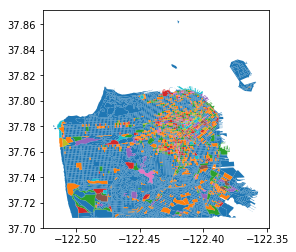

In [461]:
d[d['IDyear']==2017].plot(column='CrimeIsOther')

In [197]:
d3.head()

,Year Property Built,Assessed Land Value,Number of Units,Lot Area,GISYEARJOIN,COMH,COMM,COMO,COMR,GOVT,...,MRES,SRES,UnkownUseType,GISJOIN,A,B,C,D,S,Year
0,1923.0,291443.0,2.0,3515.625,G060075001010010112008,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2008.0
1,1923.0,297271.0,2.0,3515.625,G060075001010010112009,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2009.0
2,1923.0,303216.0,2.0,3515.625,G060075001010010112010,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2010.0
3,1923.0,302497.5,2.0,3515.625,G060075001010010112011,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2011.0
4,1923.0,304774.0,2.0,3515.625,G060075001010010112012,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0,G06007500101001011,0.0,0.5,0.0,0.5,0.0,2012.0


In [198]:
d4_property = d.merge(d3,how='left',on='GISYEARJOIN')

In [199]:
d4_property.isna().sum()

GISYEARJOIN                0
IDyear                     0
LAT                        0
LON                        0
AREA                       0
geometry                   0
GISJOIN_x                  0
Year_x                     0
Nviolations                0
Was complaint              0
Inspection Number          0
GISJOIN_y                  0
Year_y                     0
CrimeIsArson               0
CrimeIsOther               0
GISJOIN_x                  0
Structure_fire             0
Vehicle_fire               0
External_fire              0
Year_x                     0
Year Property Built    38240
Assessed Land Value    38240
Number of Units        38240
Lot Area               38240
COMH                   38240
COMM                   38240
COMO                   38240
COMR                   38240
GOVT                   38240
IND                    38240
MISC                   38240
MRES                   38240
SRES                   38240
UnkownUseType          38240
GISJOIN_y     

In [200]:
d5 = d4_property.drop(['GISJOIN_y','Year_y'],axis=1)

In [201]:
d5.columns

Index(['GISYEARJOIN', 'IDyear', 'LAT', 'LON', 'AREA', 'geometry', 'GISJOIN_x',
       'Year_x', 'Nviolations', 'Was complaint', 'Inspection Number',
       'CrimeIsArson', 'CrimeIsOther', 'GISJOIN_x', 'Structure_fire',
       'Vehicle_fire', 'External_fire', 'Year_x', 'Year Property Built',
       'Assessed Land Value', 'Number of Units', 'Lot Area', 'COMH', 'COMM',
       'COMO', 'COMR', 'GOVT', 'IND', 'MISC', 'MRES', 'SRES', 'UnkownUseType',
       'A', 'B', 'C', 'D', 'S'],
      dtype='object')

## Merge Census data

In [202]:
ALLDATA = d5
ALLDATA.to_csv("TEMP_dataframe.csv",index=False)

In [203]:
datapath = '../datasets/census_blocks/'
pop_household_type = pd.read_csv(datapath+"nhgis0002_ds172_2010_block.csv",
                                 low_memory=False)

housing_tenure = pd.read_csv(datapath+"nhgis0003_ds172_2010_block.csv",
                             low_memory=False)


In [204]:
prices_2010_tract = pd.read_csv(datapath+"nhgis0006_ds176_20105_2010_tract.csv",low_memory=False,encoding='latin-1')
gini_2010_tract = pd.read_csv(datapath+"nhgis0006_ds177_20105_2010_tract.csv",low_memory=False,encoding='latin-1')

In [205]:
prices_2010_SF = prices_2010_tract[prices_2010_tract['COUNTY']=='San Francisco County']
gini_2010_SF = gini_2010_tract[gini_2010_tract['COUNTY']=='San Francisco County']

In [206]:
gini_2010_SF = gini_2010_SF[['GISJOIN','J4TM001']]

In [207]:
prices_2010_SF = prices_2010_SF[['GISJOIN','JOIE001','JTIE001']]

In [208]:
len(prices_2010_SF)

197

In [209]:
prices_2010_SF.isna().sum()

GISJOIN     0
JOIE001     2
JTIE001    12
dtype: int64

In [210]:
SF_pop_housing = pop_household_type[pop_household_type['COUNTY']=='San Francisco County']
SF_tenure = housing_tenure[housing_tenure['COUNTY']=='San Francisco County']

In [211]:
SF_pop_housing = SF_pop_housing[['GISJOIN','URBRURALA','H7X001', 'H7X002', 'H7X003', \
    'H7X004', 'H7X005', 'H7X006', 'H7X007','H7X008', 'H8C001', 'H8C002', 'H8C003', \
    'H8C004', 'H8C005', 'H8C006','H8C007', 'H8C008', 'H8C009']]

SF_housing_type = SF_tenure[['GISJOIN','IFC001',
       'IFF001', 'IFF002', 'IFF003', 'IFF004']]

### Just merge on a block level (other datasets)

In [212]:
    merged_data = SF_pop_housing.merge(SF_housing_type,how='left',on='GISJOIN')

    merged_data['Urban'] = pd.get_dummies(merged_data['URBRURALA'],drop_first=True)
    merged = merged_data.drop('URBRURALA',axis=1)

In [213]:
merged.head()

,GISJOIN,H7X001,H7X002,H7X003,H7X004,H7X005,H7X006,H7X007,H7X008,H8C001,...,H8C006,H8C007,H8C008,H8C009,IFC001,IFF001,IFF002,IFF003,IFF004,Urban
0,G06007500101001000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,G06007500101001001,44,36,3,0,4,0,1,0,30,...,1,24,22,2,30,30,0,29,1,1
2,G06007500101001002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,G06007500101001003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,G06007500101001004,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [214]:
merged.isna().sum()

GISJOIN    0
H7X001     0
H7X002     0
H7X003     0
H7X004     0
H7X005     0
H7X006     0
H7X007     0
H7X008     0
H8C001     0
H8C002     0
H8C003     0
H8C004     0
H8C005     0
H8C006     0
H8C007     0
H8C008     0
H8C009     0
IFC001     0
IFF001     0
IFF002     0
IFF003     0
IFF004     0
Urban      0
dtype: int64

### Generate GISYEARJOIN and merge on previous

In [215]:
years = np.arange(2007,2019)

In [216]:
years

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [217]:
merged.columns

Index(['GISJOIN', 'H7X001', 'H7X002', 'H7X003', 'H7X004', 'H7X005', 'H7X006',
       'H7X007', 'H7X008', 'H8C001', 'H8C002', 'H8C003', 'H8C004', 'H8C005',
       'H8C006', 'H8C007', 'H8C008', 'H8C009', 'IFC001', 'IFF001', 'IFF002',
       'IFF003', 'IFF004', 'Urban'],
      dtype='object')

In [218]:
merged.head()

,GISJOIN,H7X001,H7X002,H7X003,H7X004,H7X005,H7X006,H7X007,H7X008,H8C001,...,H8C006,H8C007,H8C008,H8C009,IFC001,IFF001,IFF002,IFF003,IFF004,Urban
0,G06007500101001000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,G06007500101001001,44,36,3,0,4,0,1,0,30,...,1,24,22,2,30,30,0,29,1,1
2,G06007500101001002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,G06007500101001003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,G06007500101001004,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [219]:
mtest = merged.copy()

In [220]:
merged.columns

Index(['GISJOIN', 'H7X001', 'H7X002', 'H7X003', 'H7X004', 'H7X005', 'H7X006',
       'H7X007', 'H7X008', 'H8C001', 'H8C002', 'H8C003', 'H8C004', 'H8C005',
       'H8C006', 'H8C007', 'H8C008', 'H8C009', 'IFC001', 'IFF001', 'IFF002',
       'IFF003', 'IFF004', 'Urban'],
      dtype='object')

In [221]:
merged2 = SF_blocks.merge(merged,on='GISJOIN',how='left')

In [222]:
merged2.columns

Index(['GISJOIN', 'geometry', 'H7X001', 'H7X002', 'H7X003', 'H7X004', 'H7X005',
       'H7X006', 'H7X007', 'H7X008', 'H8C001', 'H8C002', 'H8C003', 'H8C004',
       'H8C005', 'H8C006', 'H8C007', 'H8C008', 'H8C009', 'IFC001', 'IFF001',
       'IFF002', 'IFF003', 'IFF004', 'Urban'],
      dtype='object')

In [223]:
o1 = list(merged['GISJOIN'])
o2 = list(merged['H7X001'])
o3 = list(merged['H7X002'])
o4 = list(merged['H7X003'])
o5 = list(merged['H7X004'])
o6 = list(merged['H7X005'])
o7 = list(merged['H7X006'])
o8 = list(merged['H7X007'])
o9 = list(merged['H7X008'])
o10 = list(merged['H8C001'])
o11 = list(merged['H8C002'])
o12 = list(merged['H8C003'])
o13 = list(merged['H8C004'])
o14 = list(merged['H8C005'])
o15 = list(merged['H8C006'])
o16 = list(merged['H8C007'])
o17 = list(merged['H8C008'])
o18 = list(merged['H8C009'])
o19 = list(merged['IFC001'])
o20 = list(merged['IFF001'])
o21 = list(merged['IFF002'])
o22 = list(merged['IFF003'])
o23 = list(merged['IFF004'])
o24 = list(merged['Urban'])
n1 = []
n2 = []
n3 = []
n4 = []
n5 = []
n6 = []
n7 = []
n8 = []
n9 = []
n10 = []
n11 = []
n12 = []
n13 = []
n14 = []
n15 = []
n16 = []
n17 = []
n18 = []
n19 = []
n20 = []
n21 = []
n22 = []
n23 = []
n24 = []
indexcount = []

In [224]:
o1[0] + '2007'

'G060075001010010002007'

In [225]:
years = np.arange(2007,2019)

In [226]:
j = 0
for i in range(len(merged)):
    
    a1 = o1[i]
    a2 = o2[i]
    a3 = o3[i]
    a4 = o4[i]
    a5 = o5[i]
    a6 = o6[i]
    a7 = o7[i]
    a8 = o8[i]
    a9 = o9[i]
    a10 = o10[i]
    a11 = o11[i]
    a12 = o12[i]
    a13 = o13[i]
    a14 = o14[i]
    a15 = o15[i]
    a16 = o16[i]
    a17 = o17[i]
    a18 = o18[i]
    a19 = o19[i]
    a20 = o20[i]
    a21 = o21[i]
    a22 = o22[i]
    a23 = o23[i]
    a24 = o24[i] 
    
    for year in years:
        
        n1.append(str(a1)+str(year))
        n2.append(a2)
        n3.append(a3)
        n4.append(a4)
        n5.append(a5)
        n6.append(a6)
        n7.append(a7)
        n8.append(a8)
        n9.append(a9)
        n10.append(a10)
        n11.append(a11)
        n12.append(a12)
        n13.append(a13)
        n14.append(a14)
        n15.append(a15)
        n16.append(a16)
        n17.append(a17)
        n18.append(a18)
        n19.append(a19)
        n20.append(a20)
        n21.append(a21)
        n22.append(a22)
        n23.append(a23)
        n24.append(a24)
        j += 1
        indexcount.append(j)

        

In [227]:
census_blocks_years = pd.DataFrame({'index':indexcount,'GISYEARJOIN':n1,'H7X001':n2, 'H7X002':n3, 'H7X003':n4,\
       'H7X004':n5, 'H7X005':n6,
       'H7X006':n7, 'H7X007':n8, 'H7X008':n9, 'H8C001':n10, 'H8C002':n11, 'H8C003':n12, 'H8C004':n13,
       'H8C005':n14, 'H8C006':n15, 'H8C007':n16, 'H8C008':n17, 'H8C009':n18, 'IFC001':n19, 'IFF001':n20,
       'IFF002':n21, 'IFF003':n22, 'IFF004':n23, 'Urban':n24})

In [228]:
census_blocks_years.head(20)

,index,GISYEARJOIN,H7X001,H7X002,H7X003,H7X004,H7X005,H7X006,H7X007,H7X008,...,H8C006,H8C007,H8C008,H8C009,IFC001,IFF001,IFF002,IFF003,IFF004,Urban
0,1,G060075001010010002007,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,G060075001010010002008,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,G060075001010010002009,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,G060075001010010002010,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,G060075001010010002011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,G060075001010010002012,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,G060075001010010002013,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,G060075001010010002014,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,G060075001010010002015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,G060075001010010002016,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
ALLDATA2 = ALLDATA.merge(census_blocks_years,on='GISYEARJOIN',how='left')

In [230]:
ALLDATA2.drop(['GISJOIN_x','Year_x','index'],inplace=True,axis=1)

In [231]:
ALLDATA2['LAT'] = ALLDATA2['LAT'].astype(float)
ALLDATA2['LON'] = ALLDATA2['LON'].astype(float)

In [232]:
ALLDATA2.isna().sum()

GISYEARJOIN                0
IDyear                     0
LAT                        0
LON                        0
AREA                       0
geometry                   0
Nviolations                0
Was complaint              0
Inspection Number          0
CrimeIsArson               0
CrimeIsOther               0
Structure_fire             0
Vehicle_fire               0
External_fire              0
Year Property Built    38240
Assessed Land Value    38240
Number of Units        38240
Lot Area               38240
COMH                   38240
COMM                   38240
COMO                   38240
COMR                   38240
GOVT                   38240
IND                    38240
MISC                   38240
MRES                   38240
SRES                   38240
UnkownUseType          38240
A                      38240
B                      38240
C                      38240
D                      38240
S                      38240
H7X001                     0
H7X002        

In [233]:
ALLDATA2.drop('geometry',axis=1).to_csv("YearDATA.csv",index=False)

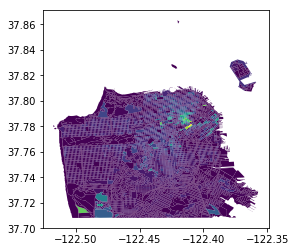

In [776]:
ALLDATA2[ALLDATA2['IDyear']==2018].plot(column='H8C007')

In [221]:
plt.style.use('ggplot')

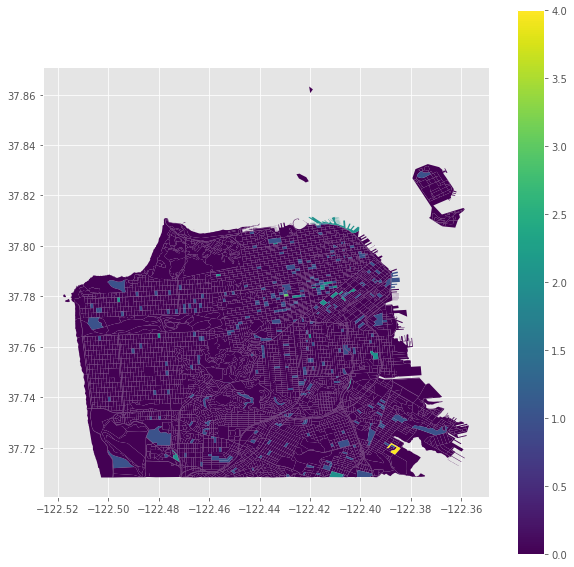

In [222]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#We should really consider this the X features dataset! 
#The y (target) needs to be whether or not there are 
#fires in the NEXT year!

ALLDATA2[ALLDATA2['IDyear']==2018].plot(column='Structure_fire',legend=True,ax=ax)

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [224]:
testdataset = ALLDATA2.dropna()

In [225]:
testdataset.columns

Index(['GISYEARJOIN', 'IDyear', 'LAT', 'LON', 'AREA', 'geometry',
       'Nviolations', 'Was complaint', 'Inspection Number', 'CrimeIsArson',
       'CrimeIsOther', 'Structure_fire', 'Vehicle_fire', 'External_fire',
       'Year Property Built', 'Assessed Land Value', 'Number of Units',
       'Lot Area', 'COMH', 'COMM', 'COMO', 'COMR', 'GOVT', 'IND', 'MISC',
       'MRES', 'SRES', 'UnkownUseType', 'A', 'B', 'C', 'D', 'S', 'H7X001',
       'H7X002', 'H7X003', 'H7X004', 'H7X005', 'H7X006', 'H7X007', 'H7X008',
       'H8C001', 'H8C002', 'H8C003', 'H8C004', 'H8C005', 'H8C006', 'H8C007',
       'H8C008', 'H8C009', 'IFC001', 'IFF001', 'IFF002', 'IFF003', 'IFF004',
       'Urban'],
      dtype='object')

In [226]:
firecols = ['Structure_fire','Vehicle_fire','External_fire']
todrop = ['GISYEARJOIN','geometry']

In [227]:
fires = testdataset[firecols]
testdataset.drop(firecols,inplace=True,axis=1)
testdataset.drop(todrop,inplace=True,axis=1)

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [228]:
def classify(val):
    
    if val >= 1:
        return 1
    else:
        return 0

In [229]:
y = fires['Vehicle_fire'].apply(classify)

In [230]:
X = testdataset

In [231]:
X.head()

,IDyear,LAT,LON,AREA,Nviolations,Was complaint,Inspection Number,CrimeIsArson,CrimeIsOther,Year Property Built,...,H8C006,H8C007,H8C008,H8C009,IFC001,IFF001,IFF002,IFF003,IFF004,Urban
0,2007,37.750067,-122.441075,16958,0.0,0.0,0.0,0.0,2.0,1928.638298,...,5,40,27,13,65,62,28,14,20,1
1,2008,37.750067,-122.441075,16958,0.0,0.0,0.0,0.0,2.0,1928.638298,...,5,40,27,13,65,62,28,14,20,1
2,2009,37.750067,-122.441075,16958,0.0,0.0,0.0,0.0,8.0,1928.638298,...,5,40,27,13,65,62,28,14,20,1
3,2010,37.750067,-122.441075,16958,0.0,0.0,0.0,1.0,6.0,1928.638298,...,5,40,27,13,65,62,28,14,20,1
4,2011,37.750067,-122.441075,16958,0.0,0.0,0.0,0.0,5.0,1929.260870,...,5,40,27,13,65,62,28,14,20,1


In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [233]:
RC = RandomForestClassifier(n_estimators=300,min_samples_leaf=1,class_weight='balanced')

In [234]:
RC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [235]:
predictionprob = RC.predict_proba(X_test)

In [236]:
fpr, tpr, thresholds1 = roc_curve(np.array(y_test).astype(int), predictionprob[:,1])

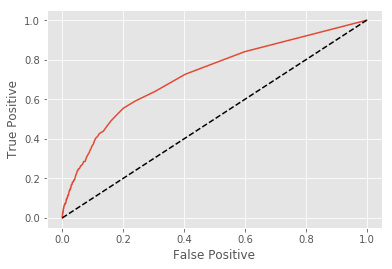

In [237]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')

In [238]:
print(RC.feature_importances_)
X.columns

[0.0372393  0.02947457 0.05024865 0.04007053 0.00438413 0.00998197
 0.02906548 0.04462911 0.10679217 0.03233341 0.05065381 0.02506652
 0.03324    0.00255208 0.00661535 0.00387111 0.01154935 0.00015577
 0.00788283 0.00406666 0.02004234 0.02346426 0.         0.00092343
 0.00200615 0.00855384 0.01034738 0.00585974 0.02345082 0.02184495
 0.02690485 0.00810385 0.02198273 0.00621248 0.02619545 0.01793552
 0.01777366 0.01714281 0.01740578 0.01647519 0.01159834 0.01713322
 0.01701751 0.01696342 0.01610079 0.01831592 0.01664561 0.02010439
 0.02272223 0.02090052 0.        ]


Index(['IDyear', 'LAT', 'LON', 'AREA', 'Nviolations', 'Was complaint',
       'Inspection Number', 'CrimeIsArson', 'CrimeIsOther',
       'Year Property Built', 'Assessed Land Value', 'Number of Units',
       'Lot Area', 'COMH', 'COMM', 'COMO', 'COMR', 'GOVT', 'IND', 'MISC',
       'MRES', 'SRES', 'UnkownUseType', 'A', 'B', 'C', 'D', 'S', 'H7X001',
       'H7X002', 'H7X003', 'H7X004', 'H7X005', 'H7X006', 'H7X007', 'H7X008',
       'H8C001', 'H8C002', 'H8C003', 'H8C004', 'H8C005', 'H8C006', 'H8C007',
       'H8C008', 'H8C009', 'IFC001', 'IFF001', 'IFF002', 'IFF003', 'IFF004',
       'Urban'],
      dtype='object')

## This is just a test to see if it works when loaded from a file
Note that this is not useful because we're predicting each year's fires from the same
years data

In [234]:
#Test if this works when loaded from csv
ALLDATA2.drop('geometry',axis=1).to_csv('ALLDATA2.csv',index=False)

In [235]:
testdataset = pd.read_csv('ALLDATA2.csv')

In [236]:
firecols = ['Structure_fire','Vehicle_fire','External_fire']
todrop = ['GISYEARJOIN']

In [237]:
testdataset.dropna(inplace=True)
fires = testdataset[firecols]
testdataset.drop(firecols,inplace=True,axis=1)
testdataset.drop(todrop,inplace=True,axis=1)

In [238]:
def classify(val):
    
    if val >= 1:
        return 1
    else:
        return 0

In [239]:
y = fires['Vehicle_fire'].apply(classify)

In [240]:
X = testdataset.dropna()

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [245]:
RC = RandomForestClassifier(n_estimators=100,min_samples_leaf=20,class_weight='balanced')

In [246]:
RC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [247]:
predictionprob = RC.predict_proba(X_test)

In [248]:
fpr, tpr, thresholds1 = roc_curve(np.array(y_test).astype(int), predictionprob[:,1])

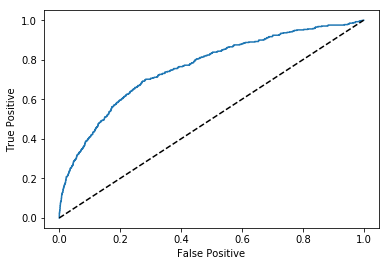

In [249]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')

### Now we want to predict FUTURE fires

Note - this works but does not include the adjusted property dates!

In [250]:
allfires = pd.read_csv("All_associated_fires.csv")

In [251]:
allfires[allfires['IDyear']==2015][['Structure_fire','Vehicle_fire','External_fire']].sum()

Structure_fire     294.0
Vehicle_fire       259.0
External_fire     1185.0
dtype: float64

In [252]:
allfires.head()

,GISYEARJOIN,IDyear,GISJOIN,Structure_fire,Vehicle_fire,External_fire,Year
0,G060075002130020022007,2007,0,0.0,0.0,0.0,0.0
1,G060075002130020022008,2008,0,0.0,0.0,0.0,0.0
2,G060075002130020022009,2009,0,0.0,0.0,0.0,0.0
3,G060075002130020022010,2010,0,0.0,0.0,0.0,0.0
4,G060075002130020022011,2011,0,0.0,0.0,0.0,0.0


We want to shift this one year into the future

In [253]:
fires_to_predict = allfires.copy()

In [254]:
fires_to_predict['GISYEARJOIN'] = fires_to_predict['GISYEARJOIN'].apply(lambda x: x[:-4]+str(int(x[-4:])-1))
fires_to_predict.columns = ['GISYEARJOIN','IDyear','GISJOIN','SF_pred','VF_pred','EF_pred','Year']

In [255]:
fires_to_predict.head()

,GISYEARJOIN,IDyear,GISJOIN,SF_pred,VF_pred,EF_pred,Year
0,G060075002130020022006,2007,0,0.0,0.0,0.0,0.0
1,G060075002130020022007,2008,0,0.0,0.0,0.0,0.0
2,G060075002130020022008,2009,0,0.0,0.0,0.0,0.0
3,G060075002130020022009,2010,0,0.0,0.0,0.0,0.0
4,G060075002130020022010,2011,0,0.0,0.0,0.0,0.0


In [256]:
allfires_with_pred = allfires.merge(fires_to_predict,on='GISYEARJOIN',how='left')

In [257]:
allfires_with_pred.head()

,GISYEARJOIN,IDyear_x,GISJOIN_x,Structure_fire,Vehicle_fire,External_fire,Year_x,IDyear_y,GISJOIN_y,SF_pred,VF_pred,EF_pred,Year_y
0,G060075002130020022007,2007,0,0.0,0.0,0.0,0.0,2008.0,0,0.0,0.0,0.0,0.0
1,G060075002130020022008,2008,0,0.0,0.0,0.0,0.0,2009.0,0,0.0,0.0,0.0,0.0
2,G060075002130020022009,2009,0,0.0,0.0,0.0,0.0,2010.0,0,0.0,0.0,0.0,0.0
3,G060075002130020022010,2010,0,0.0,0.0,0.0,0.0,2011.0,0,0.0,0.0,0.0,0.0
4,G060075002130020022011,2011,0,0.0,0.0,0.0,0.0,2012.0,0,0.0,0.0,0.0,0.0


In [258]:
ALLDATA3 = ALLDATA2.merge(fires_to_predict,on='GISYEARJOIN',how='left')

In [259]:
ALLDATA3.columns

Index(['GISYEARJOIN', 'IDyear_x', 'LAT', 'LON', 'AREA', 'geometry',
       'Nviolations', 'Was complaint', 'Inspection Number', 'CrimeIsArson',
       'CrimeIsOther', 'Structure_fire', 'Vehicle_fire', 'External_fire',
       'Year Property Built', 'Assessed Land Value', 'Number of Units',
       'Lot Area', 'COMH', 'COMM', 'COMO', 'COMR', 'GOVT', 'IND', 'MISC',
       'MRES', 'SRES', 'UnkownUseType', 'A', 'B', 'C', 'D', 'S', 'H7X001',
       'H7X002', 'H7X003', 'H7X004', 'H7X005', 'H7X006', 'H7X007', 'H7X008',
       'H8C001', 'H8C002', 'H8C003', 'H8C004', 'H8C005', 'H8C006', 'H8C007',
       'H8C008', 'H8C009', 'IFC001', 'IFF001', 'IFF002', 'IFF003', 'IFF004',
       'Urban', 'IDyear_y', 'GISJOIN', 'SF_pred', 'VF_pred', 'EF_pred',
       'Year'],
      dtype='object')

In [261]:
ALLDATA3.drop('geometry',axis=1).to_csv("Fully_merged_dataset_Jan23.csv",index=False)

In [262]:
firecols = ['SF_pred','VF_pred','EF_pred']
todrop = ['GISYEARJOIN','IDyear_x','IDyear_y','Year']

In [263]:
testdataset = ALLDATA3
testdataset.dropna(inplace=True)
fires = testdataset[firecols]
testdataset.drop(firecols,inplace=True,axis=1)
testdataset.drop(todrop,inplace=True,axis=1)

In [264]:
y = fires['EF_pred'].apply(classify)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [266]:
RC = RandomForestClassifier(n_estimators=200,min_samples_leaf=40,max_depth=8)

In [267]:
RC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [268]:
predictionprob = RC.predict_proba(X_test)

In [269]:
fpr, tpr, thresholds1 = roc_curve(np.array(y_test).astype(int), predictionprob[:,1])

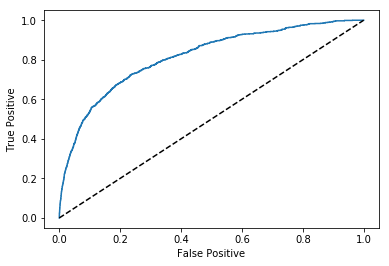

In [270]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')

In [271]:
#Area under the curve score
roc_auc_score(np.array(y_test).astype(int),predictionprob[:,1])

0.8152034248009647

In [272]:
max(predictionprob[:,1])

0.5798593226536299